In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.models
import tensorwatch as tw

In [2]:
alexnet_model = torchvision.models.alexnet()
vgg16_model = torchvision.models.vgg16()

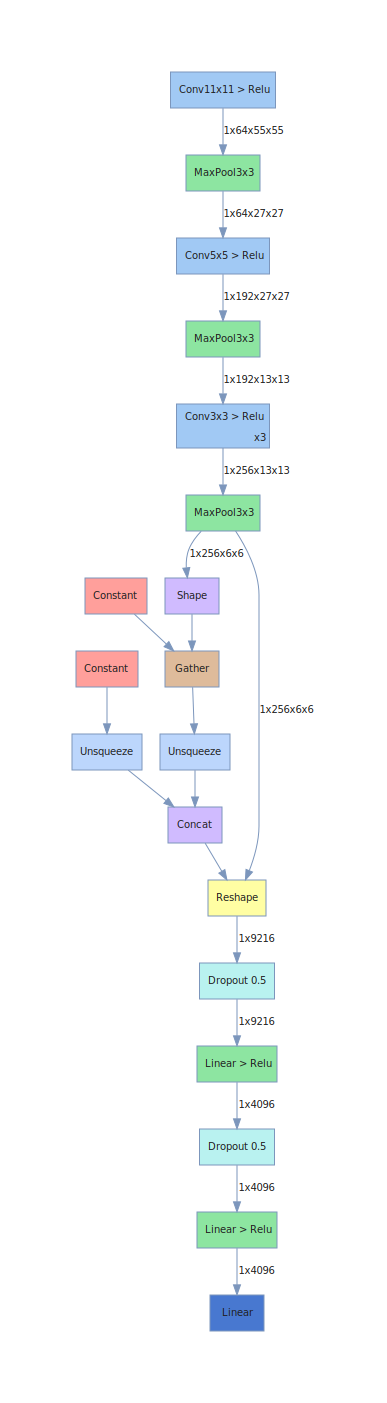

In [3]:
tw.draw_model(alexnet_model, [1, 3, 224, 224])

In [24]:
from PIL import Image
from torchvision import models, transforms
img = Image.open("D:\\datasets\\ImageNet\\train\\n01592084\\n01592084_68.JPEG")
img_t = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])(img)
img_t.unsqueeze_(0)
img_t.shape

torch.Size([1, 3, 224, 224])

In [53]:
from __future__ import division
""" 
Creates a ResNeXt Model as defined in:
Xie, S., Girshick, R., Dollar, P., Tu, Z., & He, K. (2016). 
Aggregated residual transformations for deep neural networks. 
arXiv preprint arXiv:1611.05431.
import from https://github.com/facebookresearch/ResNeXt/blob/master/models/resnext.lua
"""
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch

class Bottleneck(nn.Module):
    """
    RexNeXt bottleneck type C
    """
    expansion = 4

    def __init__(self, inplanes, planes, baseWidth, cardinality, stride=1, downsample=None):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            baseWidth: base width.
            cardinality: num of convolution groups.
            stride: conv stride. Replaces pooling layer.
        """
        super(Bottleneck, self).__init__()

        D = int(math.floor(planes * (baseWidth / 64)))
        C = cardinality

        self.conv1 = nn.Conv2d(inplanes, D*C, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(D*C)
        self.conv2 = nn.Conv2d(D*C, D*C, kernel_size=3, stride=stride, padding=1, groups=C, bias=False)
        self.bn2 = nn.BatchNorm2d(D*C)
        self.conv3 = nn.Conv2d(D*C, planes * 4, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNeXt(nn.Module):
    """
    ResNext optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1611.05431.pdf
    """
    def __init__(self, baseWidth=4, cardinality=32, layers=[3, 4, 6, 3], num_classes=1000):
        """ Constructor
        Args:
            baseWidth: baseWidth for ResNeXt.
            cardinality: number of convolution groups.
            layers: config of layers, e.g., [3, 4, 6, 3]
            num_classes: number of classes
        """
        super(ResNeXt, self).__init__()
        block = Bottleneck

        self.cardinality = cardinality
        self.baseWidth = baseWidth
        self.num_classes = num_classes
        self.inplanes = 64
        self.output_size = 64

        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], 2)
        self.layer3 = self._make_layer(block, 256, layers[2], 2)
        self.layer4 = self._make_layer(block, 512, layers[3], 2)
        self.avgpool = nn.AvgPool2d(7)      
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        """ Stack n bottleneck modules where n is inferred from the depth of the network.
        Args:
            block: block type used to construct ResNext
            planes: number of output channels (need to multiply by block.expansion)
            blocks: number of blocks to be built
            stride: factor to reduce the spatial dimensionality in the first bottleneck of the block.
        Returns: a Module consisting of n sequential bottlenecks.
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.baseWidth, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.baseWidth, self.cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        self.feature_maps = []
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        self.feature_maps.append(x)
        x = self.maxpool1(x)
        self.feature_maps.append(x)
        x = self.layer1(x)
        self.feature_maps.append(x)
        x = self.layer2(x)
        self.feature_maps.append(x)
        x = self.layer3(x)
        #self.feature_maps.append(x)
        x = self.layer4(x)
        #self.feature_maps.append(x)
        x = self.avgpool(x)
        #self.feature_maps.append(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnext50(baseWidth, cardinality):
    """
    Construct ResNeXt-50.
    """
    model = ResNeXt(baseWidth, cardinality, [3, 4, 6, 3], 1000)
    return model


def resnext101(baseWidth, cardinality):
    """
    Construct ResNeXt-101.
    """
    model = ResNeXt(baseWidth, cardinality, [3, 4, 23, 3], 1000)
    return model


def resnext152(baseWidth, cardinality):
    """
    Construct ResNeXt-152.
    """
    model = ResNeXt(baseWidth, cardinality, [3, 8, 36, 3], 1000)
    return model


In [33]:
import torch
from torch import nn
from typing import Tuple

def visualize_receptive_field(
        model: torch.nn.Module,
        input_shape: Tuple[int, ...] = (96, 96, 1),  # (H, W, C) order!
        interactive=False
) -> None:
    """Visualize analytical and effective receptive filelds of a network.
    Requires https://github.com/fornaxai/receptivefield to work
    (``pip install receptivefield``).
    Only works for 2D inputs (tensor layout (N, C, H, W)!
    Also requires that the ``model`` stores its output (or an intermediate
    layer output of interest) as ``self.feature_maps[0]`` before returning,
    (see bottom of :py:meth:`elektronn3.models.unet.UNet.forward`).
    Example::
    >>> from elektronn3.models._model_utils import visualize_receptive_field
    >>> from elektronn3.models.unet import UNet
    >>> model = UNet(
    ...     in_channels=1,
    ...     out_channels=2,
    ...     n_blocks=3,
    ...     activation='lin',
    ...     dim=2,
    ... )
    >>> input_shape = (96, 96, 1)
    >>> visualize_receptive_field(model, input_shape, interactive=True)
    input_shape = (96, 96, 1)
    visualize_receptive_field(model, input_shape, interactive=True)"""
    from receptivefield.pytorch import PytorchReceptiveField
    import matplotlib.pyplot as plt

    def model_fn():
        return model.eval()

    rf = PytorchReceptiveField(model_fn)
    rf_params = rf.compute(input_shape=input_shape)
    center = (input_shape[0] // 2, input_shape[1] // 2)

    fig, ax = plt.subplots()
    rf.plot_gradient_at(fm_id=0, point=center, axis=ax)
    if interactive:
        plt.show()
    return fig

resnext = ResNeXt()
resnext.train()
out = resnext(img_t)
visualize_receptive_field(resnext, (224, 224, 3))

[2019-03-06 00:06:28,570][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=112, h=112, c=64), GridShape(n=1, w=56, h=56, c=64), GridShape(n=1, w=56, h=56, c=256), GridShape(n=1, w=28, h=28, c=512), GridShape(n=1, w=14, h=14, c=1024), GridShape(n=1, w=7, h=7, c=2048), GridShape(n=1, w=1, h=1, c=2048)]
[2019-03-06 00:06:28,573][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=224, h=224, c=3)


IndexError: index 1 is out of bounds for dimension 2 with size 1

[2019-03-06 00:52:27,729][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=94, h=94, c=64), GridShape(n=1, w=92, h=92, c=64), GridShape(n=1, w=42, h=42, c=128), GridShape(n=1, w=17, h=17, c=256)]
[2019-03-06 00:52:27,733][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=96, h=96, c=3)
[2019-03-06 00:52:29,342][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(1.5, 1.5), stride=(1.0, 1.0), size=Size(w=3, h=3))
[2019-03-06 00:52:29,345][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(2.5, 2.5), stride=(1.0, 1.0), size=Size(w=5, h=5))
[2019-03-06 00:52:29,347][ INFO][base.py]::Estimated receptive field for feature map [2]: ReceptiveFieldDescription(offset=(7.0, 7.0), stride=(2.0, 2.0), size=Size(w=14, h=14))
[2019-03-06 00:52:29,349][ INFO][base.py]::Estimated receptive field for feature map [3]: ReceptiveFieldDescription(offset=(16.0, 16.0), stride=(4.0, 4.0), size=Size(w=32

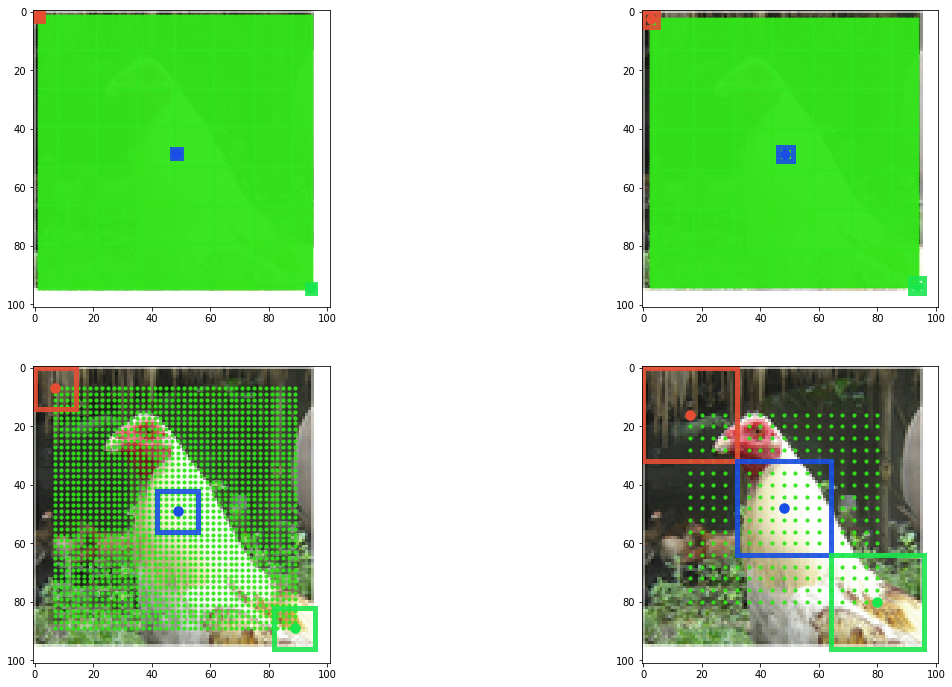

In [61]:
import torch.nn as nn
from receptivefield.pytorch import PytorchReceptiveField
from receptivefield.image import get_default_image

class Linear(nn.Module):
    """An identity activation function"""
    def forward(self, x):
        return x
# define some example feature extractor, here we compute RFs for two 
# feature maps
class SimpleVGG(nn.Module):
    def __init__(self, disable_activations: bool = False):
        """disable_activations: whether to generate network with Relus or not."""
        super(SimpleVGG, self).__init__()
        self.features = self._make_layers(disable_activations)

    def forward(self, x):
        # index of layers with feature maps
        select = [1, 3, 8, 13]
        # self.feature_maps is a list of Tensors, PytorchReceptiveField looks for 
        # this parameter and compute receptive fields for all Tensors inside it.
        self.feature_maps = []
        for l, layer in enumerate(self.features):
            x = layer(x)
            if l in select:
                self.feature_maps.append(x)
        return x

    def _make_layers(self, disable_activations: bool):
        activation = lambda: Linear() if disable_activations else nn.ReLU()
        layers = [
            nn.Conv2d(3, 64, kernel_size=3),
            activation(),
            nn.Conv2d(64, 64, kernel_size=3),
            activation(), # 3
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            activation(),
            nn.Conv2d(128, 128, kernel_size=3),
            activation(), # 8
            
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3),
            activation(),
            nn.Conv2d(256, 256, kernel_size=3),
            activation(), # 13
        ]        
        return nn.Sequential(*layers)    

# define model functions
def model_fn() -> nn.Module:
    model = SimpleVGG(disable_activations=True)
    model.eval()
    return model

input_shape = [96, 96, 3]
#input_shape = [224, 224, 3]
rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape)
img = Image.open("D:\\datasets\\ImageNet\\train\\n01514668\\n01514668_1367.JPEG")
img = img.resize((input_shape[0], input_shape[1]), Image.ANTIALIAS)
# plot receptive fields
rf.plot_rf_grids(
    custom_image=img, 
    figsize=(20, 12), 
    layout=(2, 2))

[2019-03-06 00:33:23,496][ INFO][pytorch.py]::Feature maps shape: [GridShape(n=1, w=112, h=112, c=64), GridShape(n=1, w=56, h=56, c=64), GridShape(n=1, w=56, h=56, c=256), GridShape(n=1, w=28, h=28, c=512)]
[2019-03-06 00:33:23,498][ INFO][pytorch.py]::Input shape       : GridShape(n=1, w=224, h=224, c=3)
[2019-03-06 00:33:37,161][ INFO][base.py]::Estimated receptive field for feature map [0]: ReceptiveFieldDescription(offset=(0.0, 0.0), stride=(nan, nan), size=Size(w=0, h=0))
[2019-03-06 00:33:37,164][ INFO][base.py]::Estimated receptive field for feature map [1]: ReceptiveFieldDescription(offset=(0.0, 0.0), stride=(nan, nan), size=Size(w=0, h=0))
[2019-03-06 00:33:37,165][ INFO][base.py]::Estimated receptive field for feature map [2]: ReceptiveFieldDescription(offset=(0.0, 0.0), stride=(nan, nan), size=Size(w=0, h=0))
[2019-03-06 00:33:37,168][ INFO][base.py]::Estimated receptive field for feature map [3]: ReceptiveFieldDescription(offset=(0.0, 0.0), stride=(nan, nan), size=Size(w=0,

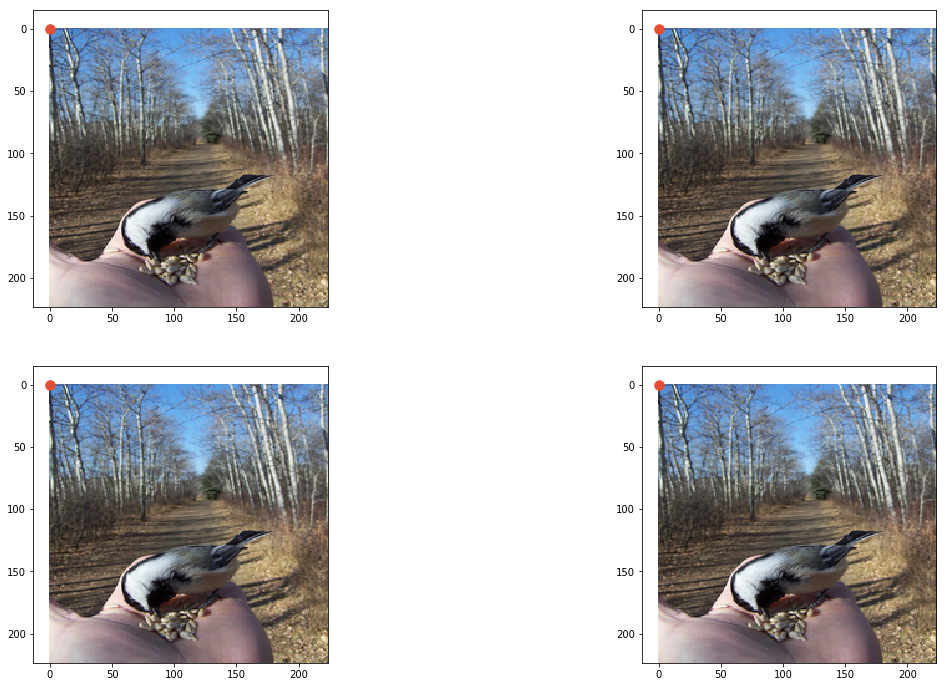

In [54]:
import torch.nn as nn
from receptivefield.pytorch import PytorchReceptiveField
from receptivefield.image import get_default_image

# define model functions
def model_fn() -> nn.Module:
    model = ResNeXt()
    model.eval()
    return model

input_shape = [224, 224, 3]
rf = PytorchReceptiveField(model_fn)
rf_params = rf.compute(input_shape = input_shape)
img = Image.open("D:\\datasets\\ImageNet\\train\\n01592084\\n01592084_68.JPEG")
img = img.resize((input_shape[0], input_shape[1]), Image.ANTIALIAS)
# plot receptive fields
rf.plot_rf_grids(
    custom_image=img, 
    figsize=(20, 12), 
    layout=(2, 2))

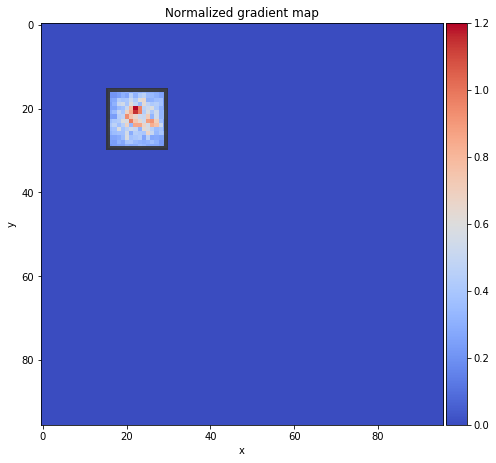

In [74]:
rf.plot_gradient_at(fm_id=2, point=(8, 8), image=None, figsize=(7, 7))

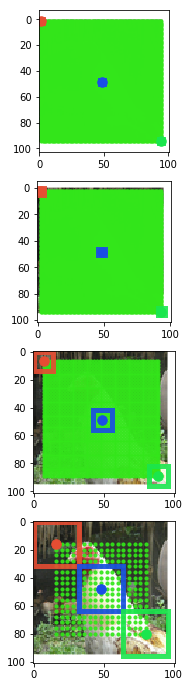

In [67]:
rf.plot_rf_grids(custom_image=img, figsize=(12,12))

In [48]:
len(resnext.feature_maps)

7